In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn import datasets, linear_model, metrics
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load the data
#df_all = pd.read_csv('data/220306_slugs_dataset.csv')
df_all = pd.read_csv('/content/drive/MyDrive/_MScDA 2021/5. Data Mining 2/CA1/data/220306_slugs_dataset.csv')
df_inp = df_all.drop(['loadCase', 'out_supReac_kN_n3', 'out_supReac_kN_n4', 'out_verDisp_mm_n5'], axis=1)
df_inp = df_inp.dropna()

# Create some new features
df_inp['densDiff'] = df_inp['slugDen'] - df_inp['pockDen']
df_inp['centrFor'] = df_inp['slugVel']**2 * df_inp['densDiff']

## Data Scaling & Splitting

In [5]:
df_scl = df_inp.copy(deep=True)
scaler = preprocessing.StandardScaler() # Scale using standard deviation
df_scl = pd.DataFrame(scaler.fit_transform(df_scl), columns = df_scl.columns, index = df_scl.index)

# Create percentile field for sratification
df_scl['splits'] = pd.qcut(df_scl['out_oopDisp_mm_n2'], 100, labels=False)

# Create train and test splits (20% test)
train, test = train_test_split(df_scl, test_size=0.20, stratify=df_scl['splits'], random_state=0) 

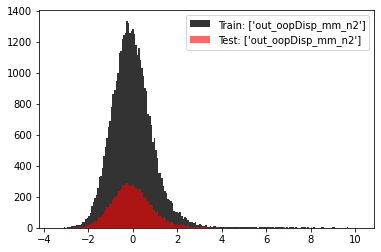

Max (train) =  10.2
Max (test) =  8.5


In [6]:
# Verify that stratification has been effective
n_bins = 200
param = ['out_oopDisp_mm_n2']
fig, axs = plt.subplots(figsize = (6, 4))
axs.hist(train[param].values, bins=n_bins, label = f'Train: {param}', color = 'black', alpha=0.8, zorder=1)
axs.hist(test[param].values, bins=n_bins, label = f'Test: {param}', color = 'red', alpha=0.6, zorder=2)
axs.legend(loc = 'upper right')
plt.show()
print('Max (train) = ', round(train[param].values.max(), 1))
print('Max (test) = ', round(test[param].values.max(), 1))

In [7]:
# Drop the splits column
train = train.drop(['splits'], axis=1)
test = test.drop(['splits'], axis=1)

## NN - Multi-output

In [8]:
from sklearn import tree
from sklearn import datasets
from sklearn import model_selection
from sklearn import metrics
from sklearn.neural_network import MLPRegressor

In [9]:
pred_target = ['out_oopDisp_mm_n2', 'out_oopDisp_mm_n5', 'out_endBend_kNm_n6']
pred_features = [
    'slugDen',  # 0
    'slugLen',  # 1
    'pockDen',  # 2
    'pockLen',  # 3
    'slugVel',  # 4
    'basePer',  # 5
    'baseAmp',  # 6
    'basePha',  # 7
    'simTime',  # 8
    'densDiff', # 9
    'centrFor'  # 10
]
pred_features = pred_features[:]
X_train = train.filter(pred_features)
y_train = train.filter(pred_target)
X_test = test.filter(pred_features)
y_test = test.filter(pred_target)

In [10]:
clf = MLPRegressor(random_state=1, max_iter=3000).fit(X_train.to_numpy(), y_train.to_numpy())
y_pred = clf.predict(X_test.to_numpy())

In [11]:
y_bas = df_inp[pred_target].to_numpy()
scaler_m = preprocessing.StandardScaler()
y_scl = scaler_m.fit_transform(y_bas)

In [12]:
# Inverse transform (scaling) to review metrics such as MAE
y = scaler_m.inverse_transform(y_test)
yhat = scaler_m.inverse_transform(y_pred)

for target in range(3):
    y_t = y[:, target]
    yhat_t = yhat[:, target]

    globals()[f'mae_momlp_{target}'] = metrics.mean_absolute_error(y_t, yhat_t)
    globals()[f'mse_momlp_{target}']  = metrics.mean_squared_error(y_t, yhat_t)
    globals()[f'rmse_momlp_{target}'] = np.sqrt(globals()[f'mse_momlp_{target}']) # or mse**(0.5)  
    r2 = metrics.r2_score(y_t, yhat_t)

    print(f'\nTarget {target+1}: Results of sklearn.metrics:')
    print("MAE:", round(globals()[f'mae_momlp_{target}'], 2))
    print("MSE:", round(globals()[f'mse_momlp_{target}'], 2))
    print("RMSE:", round(globals()[f'rmse_momlp_{target}'], 2))
    print("R-Squared:", round(r2, 2))


Target 1: Results of sklearn.metrics:
MAE: 5.16
MSE: 51.89
RMSE: 7.2
R-Squared: 0.94

Target 2: Results of sklearn.metrics:
MAE: 8.59
MSE: 144.1
RMSE: 12.0
R-Squared: 0.92

Target 3: Results of sklearn.metrics:
MAE: 14.57
MSE: 366.98
RMSE: 19.16
R-Squared: 0.89


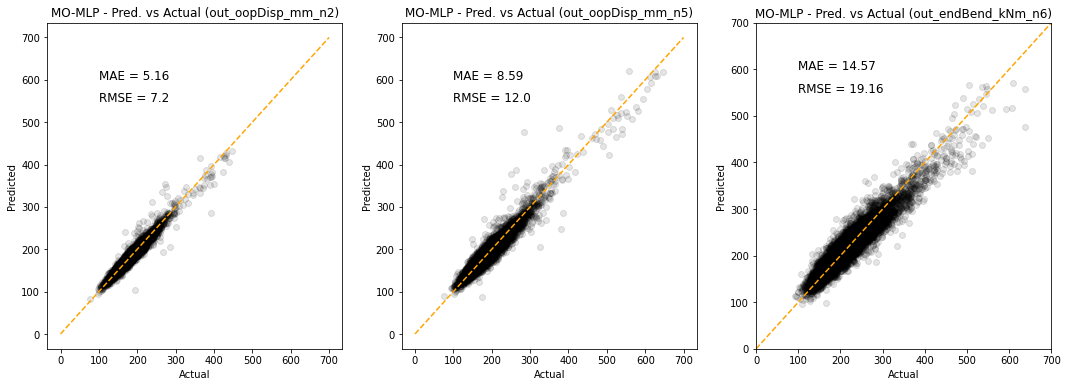

In [13]:
fig, ax = plt.subplots(1, 3, figsize = (18, 6))

for p in range(3):
    mae = round(globals()[f'mae_momlp_{p}'], 2)
    rmse = round(globals()[f'rmse_momlp_{p}'], 2)
    ax[p].scatter(y[:, p], yhat[:, p], color = 'black', zorder = 1, alpha=0.1)
    ax[p].plot([0, 700], [0, 700], '--', color = 'orange', zorder = 2)
    ax[p].set(ylabel = 'Predicted', xlabel = 'Actual')
    ax[p].set_title(f'MO-MLP - Pred. vs Actual ({pred_target[p]})')
    ax[p].text(100, 600, f'MAE = {round(mae, 2)}', fontsize = 12)
    ax[p].text(100, 550, f'RMSE = {round(rmse, 2)}', fontsize = 12)

plt.xlim(0, 700)
plt.ylim(0, 700)

plt.show()

In [ ]:
NN

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold

In [60]:
def gen_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(256, input_dim=n_inputs, activation='relu'))
    model.add(Dropout(.4))
    model.add(Dense(512, activation='relu'))   
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))    
    model.add(Dense(n_outputs, activation='linear'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

In [61]:
n_inputs, n_outputs = X_train.to_numpy().shape[1], y_train.to_numpy().shape[1]
nn_model = gen_model(n_inputs, n_outputs)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_55 (Dense)            (None, 256)               3072      
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_56 (Dense)            (None, 512)               131584    
                                                                 
 dense_57 (Dense)            (None, 1024)              525312    
                                                                 
 dense_58 (Dense)            (None, 512)               524800    
                                                                 
 dense_59 (Dense)            (None, 3)                 1539      
                                                                 
Total params: 1,186,307
Trainable params: 1,186,307
N

In [62]:
history = nn_model.fit(X_train.to_numpy(), y_train.to_numpy(), epochs=50, batch_size=128, validation_split=0.20).history

Epoch 1/50
250/250 [==============================] - 10s 37ms/step - loss: 0.3641 - val_loss: 0.2584
Epoch 2/50
250/250 [==============================] - 10s 39ms/step - loss: 0.2589 - val_loss: 0.2037
Epoch 3/50
250/250 [==============================] - 9s 38ms/step - loss: 0.2053 - val_loss: 0.1770
Epoch 4/50
250/250 [==============================] - 10s 40ms/step - loss: 0.1830 - val_loss: 0.1335
Epoch 5/50
250/250 [==============================] - 10s 39ms/step - loss: 0.1624 - val_loss: 0.1284
Epoch 6/50
250/250 [==============================] - 10s 40ms/step - loss: 0.1504 - val_loss: 0.1038
Epoch 7/50
250/250 [==============================] - 9s 38ms/step - loss: 0.1504 - val_loss: 0.1604
Epoch 8/50
250/250 [==============================] - 10s 39ms/step - loss: 0.1434 - val_loss: 0.1126
Epoch 9/50
250/250 [==============================] - 10s 40ms/step - loss: 0.1439 - val_loss: 0.1449
Epoch 10/50
250/250 [==============================] - 10s 39ms/step - loss: 0.1389 

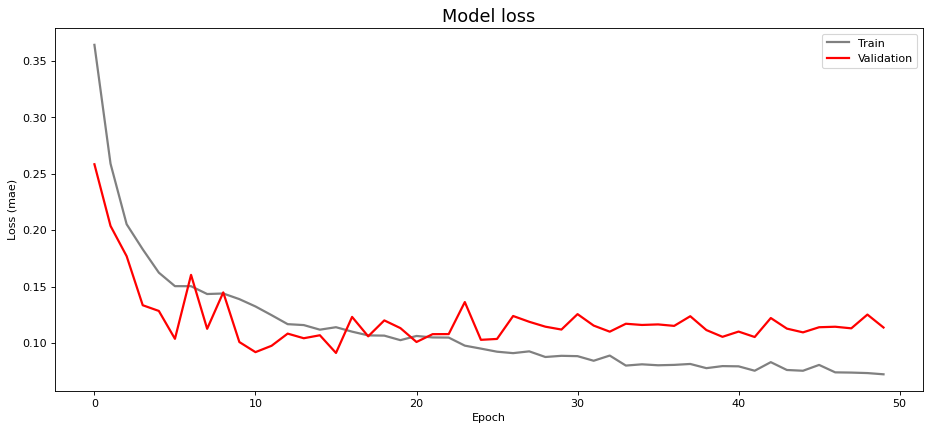

In [63]:
# Plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'grey', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [64]:
y_pred = nn_model.predict(X_test.to_numpy())
y_bas = df_inp[pred_target].to_numpy()
scaler_m = preprocessing.StandardScaler()
y_scl = scaler_m.fit_transform(y_bas)

In [65]:
# Inverse transform (scaling) to review metrics such as MAE
y = scaler_m.inverse_transform(y_test)
yhat = scaler_m.inverse_transform(y_pred)

for target in range(3):
    y_t = y[:, target]
    yhat_t = yhat[:, target]

    globals()[f'mae_momlp_{target}'] = metrics.mean_absolute_error(y_t, yhat_t)
    globals()[f'mse_momlp_{target}']  = metrics.mean_squared_error(y_t, yhat_t)
    globals()[f'rmse_momlp_{target}'] = np.sqrt(globals()[f'mse_momlp_{target}']) # or mse**(0.5)  
    r2 = metrics.r2_score(y_t, yhat_t)

    print(f'\nTarget {target+1}: Results of sklearn.metrics:')
    print("MAE:", round(globals()[f'mae_momlp_{target}'], 2))
    print("MSE:", round(globals()[f'mse_momlp_{target}'], 2))
    print("RMSE:", round(globals()[f'rmse_momlp_{target}'], 2))
    print("R-Squared:", round(r2, 2))


Target 1: Results of sklearn.metrics:
MAE: 6.45
MSE: 88.82
RMSE: 9.42
R-Squared: 0.91

Target 2: Results of sklearn.metrics:
MAE: 10.05
MSE: 227.2
RMSE: 15.07
R-Squared: 0.88

Target 3: Results of sklearn.metrics:
MAE: 16.34
MSE: 469.22
RMSE: 21.66
R-Squared: 0.86


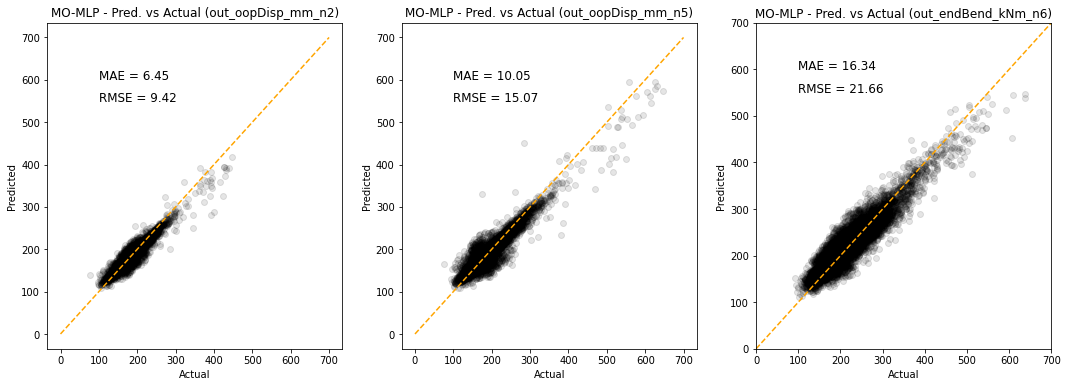

In [66]:
fig, ax = plt.subplots(1, 3, figsize = (18, 6))

for p in range(3):
    mae = round(globals()[f'mae_momlp_{p}'], 2)
    rmse = round(globals()[f'rmse_momlp_{p}'], 2)
    ax[p].scatter(y[:, p], yhat[:, p], color = 'black', zorder = 1, alpha=0.1)
    ax[p].plot([0, 700], [0, 700], '--', color = 'orange', zorder = 2)
    ax[p].set(ylabel = 'Predicted', xlabel = 'Actual')
    ax[p].set_title(f'MO-MLP - Pred. vs Actual ({pred_target[p]})')
    ax[p].text(100, 600, f'MAE = {round(mae, 2)}', fontsize = 12)
    ax[p].text(100, 550, f'RMSE = {round(rmse, 2)}', fontsize = 12)

plt.xlim(0, 700)
plt.ylim(0, 700)

plt.show()